In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision

In [11]:
from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from matplotlib import pyplot as plt
import os
from tqdm import tqdm

In [12]:
class ImageDataset(Dataset):
    def __init__(self, foldername, augfoldername=None, transform=None):
        files_as_is = [os.path.join(foldername, f) for f in os.listdir(foldername) if f.endswith(('.png', '.jpg', '.jpeg'))]
        aug_files = []
        if not augfoldername is None:
            aug_files = [os.path.join(augfoldername, f) for f in os.listdir(augfoldername) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.file_paths = [*files_as_is, *aug_files]
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, index):
        img = Image.open(self.file_paths[index]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img


In [13]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [14]:
aug_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
])

In [81]:
test_path = '/kaggle/input/cars-for-autoencoder-compression/test'
train_path = '/kaggle/input/cars-for-autoencoder-compression/train'
batch_size = 16

In [9]:
!mkdir /kaggle/working/aug_imgs

In [7]:
!mkdir /kaggle/working/model2

In [8]:
!rm -r /kaggle/working/aug_imgs/*

In [10]:
for name in tqdm(os.listdir(train_path)):
    img = Image.open(os.path.join(train_path, name))
    for i in range(4):
        aug_img = aug_transforms(img)
        aug_img.save(os.path.join('/kaggle/working/aug_imgs', f'ver_{i}'  + name))

100%|██████████| 204/204 [00:05<00:00, 35.39it/s]


In [83]:
train_dataset = ImageDataset(foldername=train_path, augfoldername='/kaggle/working/aug_imgs', transform=transform) #
test_dataset = ImageDataset(test_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [17]:
def conv_out(h_in, kernel_size, padding, stride, dilation):
    h_out = (h_in + 2 * padding - dilation * (kernel_size - 1) - 1) // stride + 1
    print(int(h_out))

def transpose_conv_out(h_in, kernel_size, padding, stride, dilation, output_padding):
    h_out = (
        (h_in - 1) * stride
        - 2 * padding
        + dilation * (kernel_size - 1)
        + output_padding
        + 1
    )
    print(int(h_out))

In [68]:
transpose_conv_out(128, kernel_size=7, padding=3, stride=1, dilation=1, output_padding=0)

128


In [8]:
conv_out(h_in=32, kernel_size=7, padding=3, stride=1, dilation=1)

32


In [61]:
class Conv_Layer_k3_hwdiv2(nn.Module):
    def __init__(self, in_channels, out_channels, activation = nn.ReLU(), norm=False):
        super(Conv_Layer_k3_hwdiv2, self).__init__()
        self.normalize = norm
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.activation = activation

    def forward(self, x):
        x = self.conv(x)
        if self.normalize:
            x = self.batch_norm(x)
        x = self.activation(x)
        return x

class TConv_Layer_k3_hwx2(nn.Module):
    def __init__(self, in_channels, out_channels, activation = nn.ReLU()):
        super(TConv_Layer_k3_hwx2, self).__init__()
        self.layer = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            activation
        )

    def forward(self, x):
        x = self.layer(x)
        return x
    
class TConv_Layer_k7_hwinit(nn.Module):
    def __init__(self, in_channels, out_channels, activation = nn.ReLU()):
        super(TConv_Layer_k7_hwinit, self).__init__()
        self.layer = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=7, stride=1, padding=3, output_padding=0, bias=False),
            activation
        )

    def forward(self, x):
        x = self.layer(x)
        return x

In [53]:
class Conv_Layer_k7_norm(nn.Module):
    def __init__(self, in_channels, out_channels, activation = nn.ReLU()):
        super(Conv_Layer_k7_norm, self).__init__()
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=7, stride=1, padding=3)
        self.activation = activation

    def forward(self, x):
        x = self.conv(x)
        x = self.batch_norm(x)
        x = self.activation(x)
        return x
    
class ResidualBlock_k3(nn.Module):
    def __init__(self, channels, activation = nn.ReLU()):
        super(ResidualBlock_k3, self).__init__()
        self.activation = activation
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            self.activation,
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
        )
    
    def forward(self, x):
        skip_x = x
        x = self.block(x)
        return self.activation(x)

In [74]:
class ResidualAE(nn.Module):
    def __init__(self, in_channels=128, hid_channels=16, hw_start = 128, hw_end = 16, activation=nn.ReLU()):
        super(ResidualAE, self).__init__()
        
        assert ((in_channels & (in_channels-1) == 0) and in_channels != 0)
        assert ((hid_channels & (hid_channels-1) == 0) and hid_channels != 0)
        assert (hid_channels < in_channels)
        
        assert ((hw_start & (hw_start-1) == 0) and hw_start != 0)
        assert ((hw_end & (hw_end-1) == 0) and hw_end != 0)
        assert (hw_end < hw_start)
        
        self.enc_layers = self._initialize_enc_layers(in_channels, 
                                                      hid_channels, 
                                                      hw_start, 
                                                      hw_end, 
                                                      activation)
        self.dec_layers = self._initialize_dec_layers(in_channels, 
                                                      hid_channels,
                                                      hw_start, 
                                                      hw_end, 
                                                      activation)
        self.Encoder = nn.Sequential(*self.enc_layers)
        self.Decoder = nn.Sequential(*self.dec_layers)
        
    def _initialize_enc_layers(self, 
                               in_channels, 
                               hid_channels, 
                               hw_start, 
                               hw_end, 
                               activation):
        modules = []
        modules.append(Conv_Layer_k7_norm(in_channels=3, out_channels=in_channels, activation=activation))
        cur_channels = in_channels
        cur_hw = hw_start
        while cur_channels != hid_channels and cur_hw != hw_end:
            modules.append(ResidualBlock_k3(cur_channels, activation))
            modules.append(Conv_Layer_k3_hwdiv2(cur_channels, cur_channels//2, activation, norm=True))
            cur_channels //= 2
            cur_hw //= 2
        return modules
    
    def _initialize_dec_layers(self, 
                               in_channels, 
                               hid_channels, 
                               hw_start, 
                               hw_end, 
                               activation):
        modules = []
        cur_channels = hid_channels
        cur_hw = hw_end
        while cur_channels != in_channels and cur_hw != hw_start:
            modules.append(TConv_Layer_k3_hwx2(cur_channels, cur_channels*2, activation))
            modules.append(ResidualBlock_k3(cur_channels*2, activation))
            cur_channels *= 2
            cur_hw *= 2
        modules.append(TConv_Layer_k7_hwinit(in_channels=cur_channels, out_channels=3, activation=activation))
        return modules
    
    def forward(self, x, b_t=None):
        x = self.Encoder(x)
        if self.training and b_t is not None:
            max_val = x.max() / (2 ** (b_t + 1))
            noise = torch.rand_like(x) * max_val
            x = x + noise
        x = self.Decoder(x)
        return x

In [11]:
class BaseAutoEncoder(nn.Module):
    def __init__(self, hid_channels = 16, in_channels = 3):
        super().__init__()
        self.encoder = ConvEncoder(in_channels, hid_channels)
        self.decoder = TConvDecoder(hid_channels, in_channels)
        
    def forward(self, x, b_t=3):
        x = self.encoder(x)
        if self.training and b_t is not None:
            max_val = x.max() / (2 ** (b_t + 1))
            noise = torch.rand_like(x) * max_val
            x = x + noise
        x = self.decoder(x)
        return x

In [58]:
def PSNR(y_true, y_pred):
    max_pixel = 1.0
    mse = torch.mean(torch.square(y_pred - y_true))
    if mse == 0:
        return float('inf')  # consistent handling of zero MSE
    return (10 * torch.log10(max_pixel ** 2 / mse)).item()

In [88]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

test_img = Image.open("/kaggle/input/cars-for-autoencoder-compression/test/10.png").convert('RGB')
test_img = transform(test_img).to('cuda:0')
test_img2 = Image.open("/kaggle/input/cars-for-autoencoder-compression/test/4.png").convert('RGB')
test_img2 = transform(test_img2).to('cuda:0')

show_transform = transforms.ToPILImage()

def train(model, data, epochs=100, lr=1e-3):
    losses = []
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=1, gamma=0.97, verbose=True)
    for epoch in range(1, epochs + 1):
        print(f"Epoch: {epoch}/{epochs}")
        pbar = tqdm(data)
        cur_losses = []
        for x in pbar:
            x = x.to(device)
            opt.zero_grad()
            x_hat = model(x)
            loss = F.mse_loss(x, x_hat)
            #loss = F.mse_loss(x, x_hat) + model.vq_loss
            loss.backward()
            opt.step()

            pbar.set_postfix({'loss': loss.item()})
            cur_losses.append(loss.item())
        losses.append(np.array(cur_losses).mean())
        scheduler.step()
        if epoch % 50:
            with torch.no_grad():
                x_test = model(test_img.unsqueeze(0))
                x_test2 = model(test_img2.unsqueeze(0))
            psnr = PSNR(test_img, x_test)
            psnr2 = PSNR(test_img2, x_test2)
            img = show_transform(x_test.squeeze(0).cpu().detach())
            img2 = show_transform(x_test2.squeeze(0).cpu().detach())
            print(f'PSNR1 = {psnr}')
            display(img)
            print(f'PSNR2 = {psnr2}')
            display(img2)
        if epoch % 10 == 0:
            torch.save(model.state_dict(), '/kaggle/working/model2/model2.ckpt')
    plt.plot(losses)
    plt.show()

In [59]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [17]:
basemodel = BaseAutoEncoder().to(device)

In [ ]:
basemodel.load_state_dict(torch.load('/kaggle/working/model/model.ckpt'))
basemodel.train()

In [87]:
RAE = ResidualAE(in_channels=128, hid_channels=16, hw_start = 128, hw_end = 16, activation=nn.ReLU()).to(device)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 1/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.0146]

Adjusting learning rate of group 0 to 9.7000e-04.
PSNR1 = 19.95126724243164


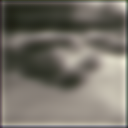

PSNR2 = 17.584314346313477


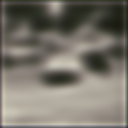

Epoch: 2/200


100%|██████████| 64/64 [00:17<00:00,  3.76it/s, loss=0.0126]

Adjusting learning rate of group 0 to 9.4090e-04.
PSNR1 = 20.46103286743164


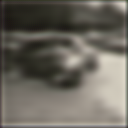

PSNR2 = 16.181657791137695


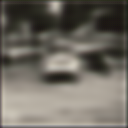

Epoch: 3/200


100%|██████████| 64/64 [00:16<00:00,  3.82it/s, loss=0.0104] 

Adjusting learning rate of group 0 to 9.1267e-04.
PSNR1 = 20.769309997558594


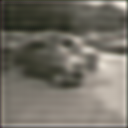

PSNR2 = 17.330524444580078


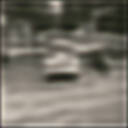

Epoch: 4/200


100%|██████████| 64/64 [00:16<00:00,  3.84it/s, loss=0.0109] 

Adjusting learning rate of group 0 to 8.8529e-04.
PSNR1 = 21.68657684326172


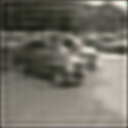

PSNR2 = 17.817039489746094


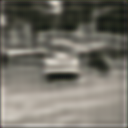

Epoch: 5/200


100%|██████████| 64/64 [00:16<00:00,  3.85it/s, loss=0.00947]

Adjusting learning rate of group 0 to 8.5873e-04.
PSNR1 = 22.495038986206055


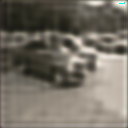

PSNR2 = 18.13579750061035


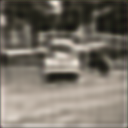

Epoch: 6/200


100%|██████████| 64/64 [00:16<00:00,  3.83it/s, loss=0.00768]

Adjusting learning rate of group 0 to 8.3297e-04.
PSNR1 = 21.619083404541016


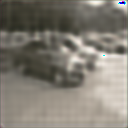

PSNR2 = 21.335086822509766


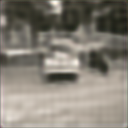

Epoch: 7/200


100%|██████████| 64/64 [00:16<00:00,  3.81it/s, loss=0.00723]

Adjusting learning rate of group 0 to 8.0798e-04.
PSNR1 = 21.755352020263672


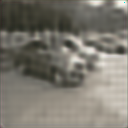

PSNR2 = 19.684412002563477


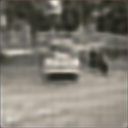

Epoch: 8/200


100%|██████████| 64/64 [00:16<00:00,  3.81it/s, loss=0.008]  

Adjusting learning rate of group 0 to 7.8374e-04.
PSNR1 = 21.307437896728516


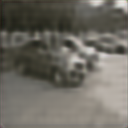

PSNR2 = 16.85190200805664


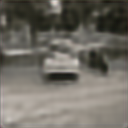

Epoch: 9/200


100%|██████████| 64/64 [00:16<00:00,  3.82it/s, loss=0.00807]

Adjusting learning rate of group 0 to 7.6023e-04.
PSNR1 = 22.73311996459961


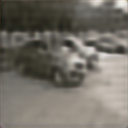

PSNR2 = 18.277393341064453


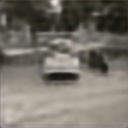

Epoch: 10/200


100%|██████████| 64/64 [00:16<00:00,  3.84it/s, loss=0.00674]

Adjusting learning rate of group 0 to 7.3742e-04.
PSNR1 = 20.92184829711914


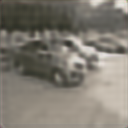

PSNR2 = 20.469436645507812


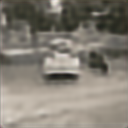

Epoch: 11/200


100%|██████████| 64/64 [00:16<00:00,  3.82it/s, loss=0.00927]

Adjusting learning rate of group 0 to 7.1530e-04.
PSNR1 = 21.90391731262207


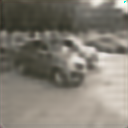

PSNR2 = 21.800094604492188


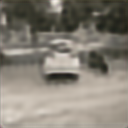

Epoch: 12/200


100%|██████████| 64/64 [00:16<00:00,  3.82it/s, loss=0.00599]

Adjusting learning rate of group 0 to 6.9384e-04.
PSNR1 = 21.501863479614258


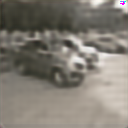

PSNR2 = 21.42337417602539


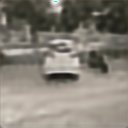

Epoch: 13/200


100%|██████████| 64/64 [00:16<00:00,  3.81it/s, loss=0.00609]

Adjusting learning rate of group 0 to 6.7303e-04.
PSNR1 = 22.820945739746094


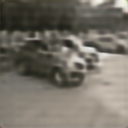

PSNR2 = 18.57101058959961


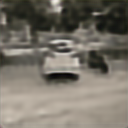

Epoch: 14/200


100%|██████████| 64/64 [00:16<00:00,  3.81it/s, loss=0.00596]

Adjusting learning rate of group 0 to 6.5284e-04.
PSNR1 = 23.362646102905273


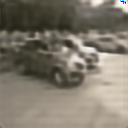

PSNR2 = 20.705474853515625


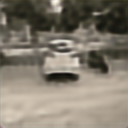

Epoch: 15/200


100%|██████████| 64/64 [00:16<00:00,  3.81it/s, loss=0.00595]

Adjusting learning rate of group 0 to 6.3325e-04.
PSNR1 = 22.314271926879883


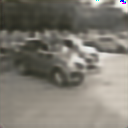

PSNR2 = 21.291744232177734


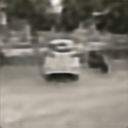

Epoch: 16/200


100%|██████████| 64/64 [00:16<00:00,  3.82it/s, loss=0.00798]

Adjusting learning rate of group 0 to 6.1425e-04.
PSNR1 = 23.576141357421875


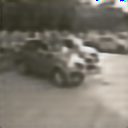

PSNR2 = 20.154285430908203


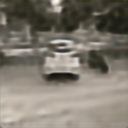

Epoch: 17/200


100%|██████████| 64/64 [00:16<00:00,  3.81it/s, loss=0.0057] 

Adjusting learning rate of group 0 to 5.9583e-04.
PSNR1 = 21.809614181518555


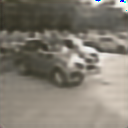

PSNR2 = 21.485998153686523


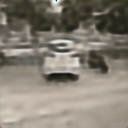

Epoch: 18/200


100%|██████████| 64/64 [00:16<00:00,  3.81it/s, loss=0.00571]

Adjusting learning rate of group 0 to 5.7795e-04.
PSNR1 = 23.170799255371094


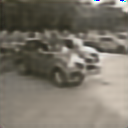

PSNR2 = 19.403404235839844


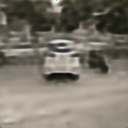

Epoch: 19/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.00882]

Adjusting learning rate of group 0 to 5.6061e-04.
PSNR1 = 23.2626953125


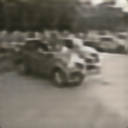

PSNR2 = 18.92169952392578


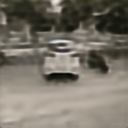

Epoch: 20/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.00574]

Adjusting learning rate of group 0 to 5.4379e-04.
PSNR1 = 24.492267608642578


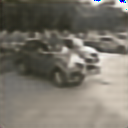

PSNR2 = 19.84503746032715


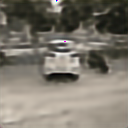

Epoch: 21/200


100%|██████████| 64/64 [00:16<00:00,  3.81it/s, loss=0.00551]

Adjusting learning rate of group 0 to 5.2748e-04.
PSNR1 = 23.69124984741211


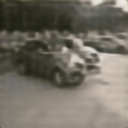

PSNR2 = 18.201231002807617


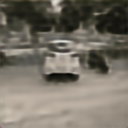

Epoch: 22/200


100%|██████████| 64/64 [00:16<00:00,  3.81it/s, loss=0.00566]

Adjusting learning rate of group 0 to 5.1166e-04.
PSNR1 = 22.35875701904297


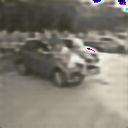

PSNR2 = 22.04078483581543


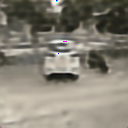

Epoch: 23/200


100%|██████████| 64/64 [00:16<00:00,  3.82it/s, loss=0.00586]

Adjusting learning rate of group 0 to 4.9631e-04.
PSNR1 = 23.746265411376953


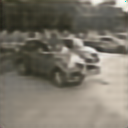

PSNR2 = 19.892366409301758


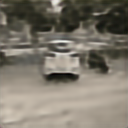

Epoch: 24/200


100%|██████████| 64/64 [00:16<00:00,  3.82it/s, loss=0.00721]

Adjusting learning rate of group 0 to 4.8142e-04.
PSNR1 = 22.693130493164062


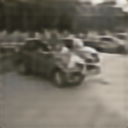

PSNR2 = 17.81134796142578


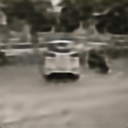

Epoch: 25/200


100%|██████████| 64/64 [00:16<00:00,  3.81it/s, loss=0.00572]

Adjusting learning rate of group 0 to 4.6697e-04.
PSNR1 = 23.712398529052734


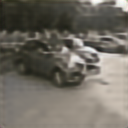

PSNR2 = 17.705801010131836


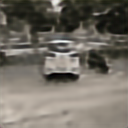

Epoch: 26/200


100%|██████████| 64/64 [00:16<00:00,  3.81it/s, loss=0.00535]

Adjusting learning rate of group 0 to 4.5297e-04.
PSNR1 = 23.953094482421875


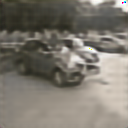

PSNR2 = 20.780332565307617


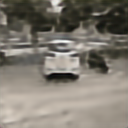

Epoch: 27/200


100%|██████████| 64/64 [00:16<00:00,  3.81it/s, loss=0.00513]

Adjusting learning rate of group 0 to 4.3938e-04.
PSNR1 = 23.019664764404297


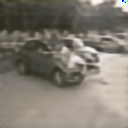

PSNR2 = 21.833454132080078


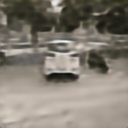

Epoch: 28/200


100%|██████████| 64/64 [00:16<00:00,  3.82it/s, loss=0.00524]

Adjusting learning rate of group 0 to 4.2620e-04.
PSNR1 = 24.400524139404297


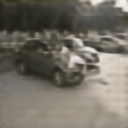

PSNR2 = 18.651086807250977


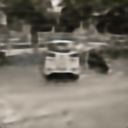

Epoch: 29/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.00526]

Adjusting learning rate of group 0 to 4.1341e-04.
PSNR1 = 22.807861328125


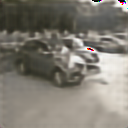

PSNR2 = 21.837905883789062


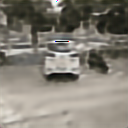

Epoch: 30/200


100%|██████████| 64/64 [00:16<00:00,  3.81it/s, loss=0.00388]

Adjusting learning rate of group 0 to 4.0101e-04.
PSNR1 = 23.079898834228516


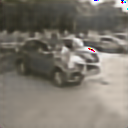

PSNR2 = 20.883525848388672


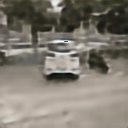

Epoch: 31/200


100%|██████████| 64/64 [00:16<00:00,  3.81it/s, loss=0.00466]

Adjusting learning rate of group 0 to 3.8898e-04.
PSNR1 = 23.893003463745117


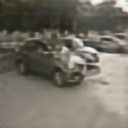

PSNR2 = 18.853347778320312


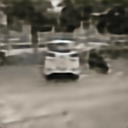

Epoch: 32/200


100%|██████████| 64/64 [00:16<00:00,  3.81it/s, loss=0.0046] 

Adjusting learning rate of group 0 to 3.7731e-04.
PSNR1 = 24.475317001342773


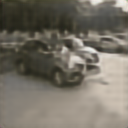

PSNR2 = 19.071924209594727


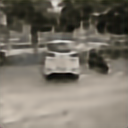

Epoch: 33/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.00454]

Adjusting learning rate of group 0 to 3.6599e-04.
PSNR1 = 24.493247985839844


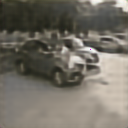

PSNR2 = 18.630321502685547


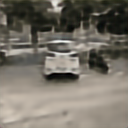

Epoch: 34/200


100%|██████████| 64/64 [00:16<00:00,  3.81it/s, loss=0.00621]

Adjusting learning rate of group 0 to 3.5501e-04.
PSNR1 = 25.03216552734375


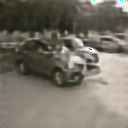

PSNR2 = 19.42702865600586


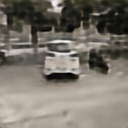

Epoch: 35/200


100%|██████████| 64/64 [00:16<00:00,  3.81it/s, loss=0.0051] 

Adjusting learning rate of group 0 to 3.4436e-04.
PSNR1 = 23.11136245727539


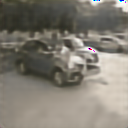

PSNR2 = 22.6138973236084


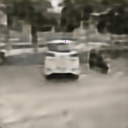

Epoch: 36/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.00588]

Adjusting learning rate of group 0 to 3.3403e-04.
PSNR1 = 22.905670166015625


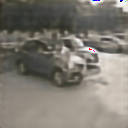

PSNR2 = 21.648738861083984


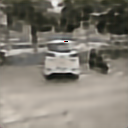

Epoch: 37/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.00622]

Adjusting learning rate of group 0 to 3.2401e-04.
PSNR1 = 24.49701690673828


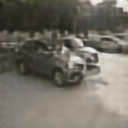

PSNR2 = 18.645362854003906


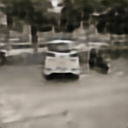

Epoch: 38/200


100%|██████████| 64/64 [00:16<00:00,  3.81it/s, loss=0.00484]

Adjusting learning rate of group 0 to 3.1429e-04.
PSNR1 = 24.011638641357422


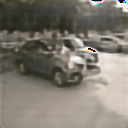

PSNR2 = 21.837299346923828


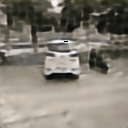

Epoch: 39/200


100%|██████████| 64/64 [00:16<00:00,  3.81it/s, loss=0.00459]

Adjusting learning rate of group 0 to 3.0486e-04.
PSNR1 = 22.9749698638916


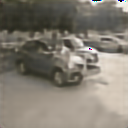

PSNR2 = 22.464038848876953


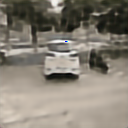

Epoch: 40/200


100%|██████████| 64/64 [00:16<00:00,  3.81it/s, loss=0.00395]

Adjusting learning rate of group 0 to 2.9571e-04.
PSNR1 = 24.11562156677246


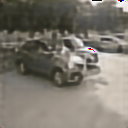

PSNR2 = 21.01763916015625


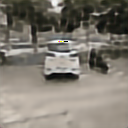

Epoch: 41/200


100%|██████████| 64/64 [00:16<00:00,  3.79it/s, loss=0.0041] 

Adjusting learning rate of group 0 to 2.8684e-04.
PSNR1 = 23.73853302001953


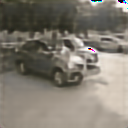

PSNR2 = 21.982559204101562


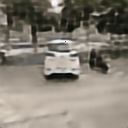

Epoch: 42/200


100%|██████████| 64/64 [00:16<00:00,  3.81it/s, loss=0.00356]

Adjusting learning rate of group 0 to 2.7824e-04.
PSNR1 = 22.44778060913086


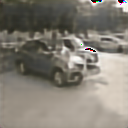

PSNR2 = 23.013031005859375


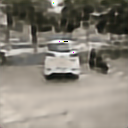

Epoch: 43/200


100%|██████████| 64/64 [00:16<00:00,  3.81it/s, loss=0.00469]

Adjusting learning rate of group 0 to 2.6989e-04.
PSNR1 = 25.15193748474121


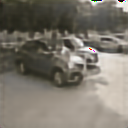

PSNR2 = 20.749893188476562


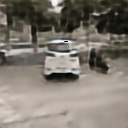

Epoch: 44/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.00464]

Adjusting learning rate of group 0 to 2.6179e-04.
PSNR1 = 24.195335388183594


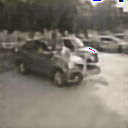

PSNR2 = 20.811386108398438


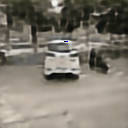

Epoch: 45/200


100%|██████████| 64/64 [00:16<00:00,  3.81it/s, loss=0.00475]

Adjusting learning rate of group 0 to 2.5394e-04.
PSNR1 = 25.02191162109375


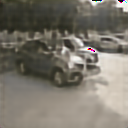

PSNR2 = 20.66341781616211


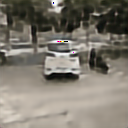

Epoch: 46/200


100%|██████████| 64/64 [00:16<00:00,  3.81it/s, loss=0.00455]

Adjusting learning rate of group 0 to 2.4632e-04.
PSNR1 = 24.598175048828125


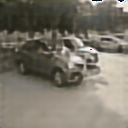

PSNR2 = 20.58086585998535


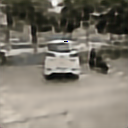

Epoch: 47/200


100%|██████████| 64/64 [00:16<00:00,  3.79it/s, loss=0.00411]

Adjusting learning rate of group 0 to 2.3893e-04.
PSNR1 = 25.292381286621094


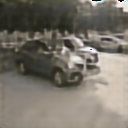

PSNR2 = 20.619598388671875


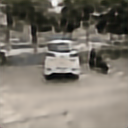

Epoch: 48/200


100%|██████████| 64/64 [00:16<00:00,  3.81it/s, loss=0.00487]

Adjusting learning rate of group 0 to 2.3176e-04.
PSNR1 = 25.152013778686523


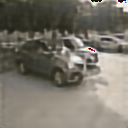

PSNR2 = 20.613849639892578


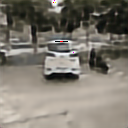

Epoch: 49/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.00471]

Adjusting learning rate of group 0 to 2.2481e-04.
PSNR1 = 25.888805389404297


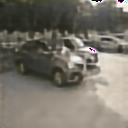

PSNR2 = 20.306045532226562


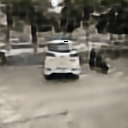

Epoch: 50/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.00403]


Adjusting learning rate of group 0 to 2.1807e-04.
Epoch: 51/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.00368]

Adjusting learning rate of group 0 to 2.1152e-04.
PSNR1 = 25.358707427978516


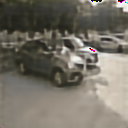

PSNR2 = 19.64779281616211


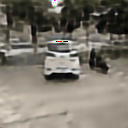

Epoch: 52/200


100%|██████████| 64/64 [00:16<00:00,  3.81it/s, loss=0.00446]

Adjusting learning rate of group 0 to 2.0518e-04.
PSNR1 = 25.227310180664062


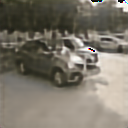

PSNR2 = 21.09491729736328


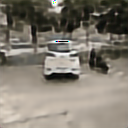

Epoch: 53/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.00363]

Adjusting learning rate of group 0 to 1.9902e-04.
PSNR1 = 25.711118698120117


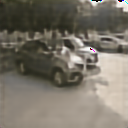

PSNR2 = 20.271406173706055


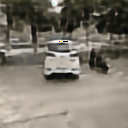

Epoch: 54/200


100%|██████████| 64/64 [00:16<00:00,  3.81it/s, loss=0.00408]

Adjusting learning rate of group 0 to 1.9305e-04.
PSNR1 = 24.83953094482422


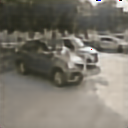

PSNR2 = 21.038803100585938


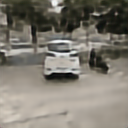

Epoch: 55/200


100%|██████████| 64/64 [00:16<00:00,  3.81it/s, loss=0.00477]

Adjusting learning rate of group 0 to 1.8726e-04.
PSNR1 = 24.833486557006836


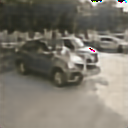

PSNR2 = 21.132408142089844


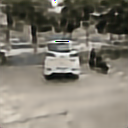

Epoch: 56/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.0036] 

Adjusting learning rate of group 0 to 1.8164e-04.
PSNR1 = 24.058547973632812


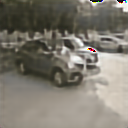

PSNR2 = 21.794048309326172


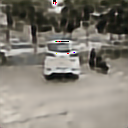

Epoch: 57/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.00413]

Adjusting learning rate of group 0 to 1.7619e-04.
PSNR1 = 25.69183349609375


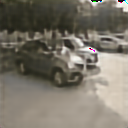

PSNR2 = 20.625951766967773


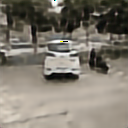

Epoch: 58/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.00401]

Adjusting learning rate of group 0 to 1.7091e-04.
PSNR1 = 25.51506805419922


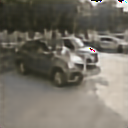

PSNR2 = 19.75679588317871


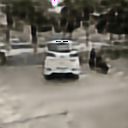

Epoch: 59/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.00395]

Adjusting learning rate of group 0 to 1.6578e-04.
PSNR1 = 25.65826416015625


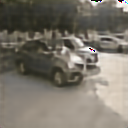

PSNR2 = 20.903425216674805


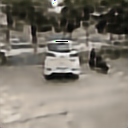

Epoch: 60/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.00332]

Adjusting learning rate of group 0 to 1.6081e-04.
PSNR1 = 25.718826293945312


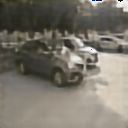

PSNR2 = 20.963993072509766


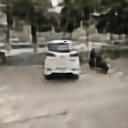

Epoch: 61/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.00464]

Adjusting learning rate of group 0 to 1.5598e-04.
PSNR1 = 25.071285247802734


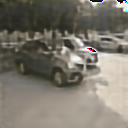

PSNR2 = 21.44922637939453


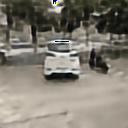

Epoch: 62/200


100%|██████████| 64/64 [00:16<00:00,  3.81it/s, loss=0.00331]

Adjusting learning rate of group 0 to 1.5130e-04.
PSNR1 = 25.35846519470215


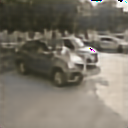

PSNR2 = 20.822906494140625


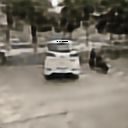

Epoch: 63/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.00427]

Adjusting learning rate of group 0 to 1.4676e-04.
PSNR1 = 25.061893463134766


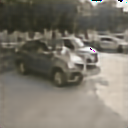

PSNR2 = 21.603792190551758


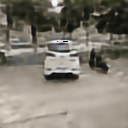

Epoch: 64/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.00379]

Adjusting learning rate of group 0 to 1.4236e-04.
PSNR1 = 25.695892333984375


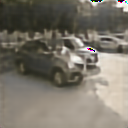

PSNR2 = 21.02318572998047


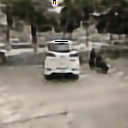

Epoch: 65/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.00347]

Adjusting learning rate of group 0 to 1.3809e-04.
PSNR1 = 24.85492706298828


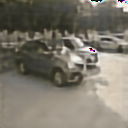

PSNR2 = 21.64668083190918


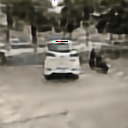

Epoch: 66/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.0041] 

Adjusting learning rate of group 0 to 1.3395e-04.
PSNR1 = 25.260135650634766


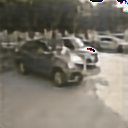

PSNR2 = 21.57410430908203


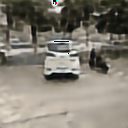

Epoch: 67/200


100%|██████████| 64/64 [00:16<00:00,  3.81it/s, loss=0.00353]

Adjusting learning rate of group 0 to 1.2993e-04.
PSNR1 = 25.520755767822266


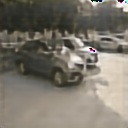

PSNR2 = 21.081907272338867


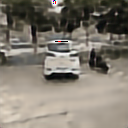

Epoch: 68/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.00398]

Adjusting learning rate of group 0 to 1.2603e-04.
PSNR1 = 24.89459800720215


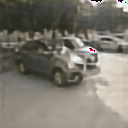

PSNR2 = 22.086763381958008


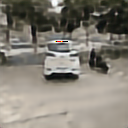

Epoch: 69/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.00397]

Adjusting learning rate of group 0 to 1.2225e-04.
PSNR1 = 25.245820999145508


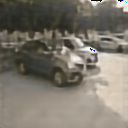

PSNR2 = 21.80722999572754


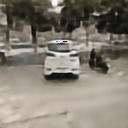

Epoch: 70/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.004]  

Adjusting learning rate of group 0 to 1.1858e-04.
PSNR1 = 25.85024070739746


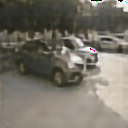

PSNR2 = 20.41992950439453


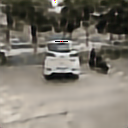

Epoch: 71/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.00416]

Adjusting learning rate of group 0 to 1.1503e-04.
PSNR1 = 24.62997817993164


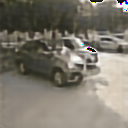

PSNR2 = 21.565509796142578


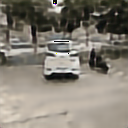

Epoch: 72/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.00396]

Adjusting learning rate of group 0 to 1.1157e-04.
PSNR1 = 25.295307159423828


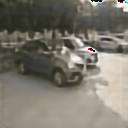

PSNR2 = 21.717784881591797


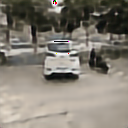

Epoch: 73/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.0051] 

Adjusting learning rate of group 0 to 1.0823e-04.
PSNR1 = 25.655750274658203


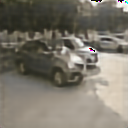

PSNR2 = 21.62796401977539


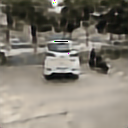

Epoch: 74/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.00408]

Adjusting learning rate of group 0 to 1.0498e-04.
PSNR1 = 25.468461990356445


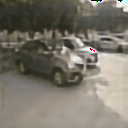

PSNR2 = 21.552349090576172


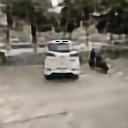

Epoch: 75/200


100%|██████████| 64/64 [00:16<00:00,  3.81it/s, loss=0.00394]

Adjusting learning rate of group 0 to 1.0183e-04.
PSNR1 = 25.206295013427734


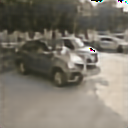

PSNR2 = 22.052335739135742


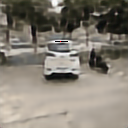

Epoch: 76/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.00414]

Adjusting learning rate of group 0 to 9.8776e-05.
PSNR1 = 25.826902389526367


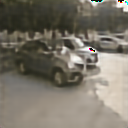

PSNR2 = 21.005229949951172


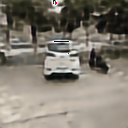

Epoch: 77/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.00313]

Adjusting learning rate of group 0 to 9.5813e-05.
PSNR1 = 25.93759536743164


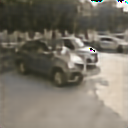

PSNR2 = 21.572708129882812


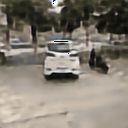

Epoch: 78/200


100%|██████████| 64/64 [00:16<00:00,  3.81it/s, loss=0.00348]

Adjusting learning rate of group 0 to 9.2938e-05.
PSNR1 = 25.89344024658203


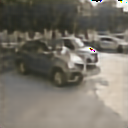

PSNR2 = 21.358497619628906


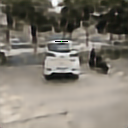

Epoch: 79/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.00386]

Adjusting learning rate of group 0 to 9.0150e-05.
PSNR1 = 25.642288208007812


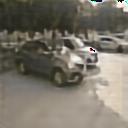

PSNR2 = 21.460002899169922


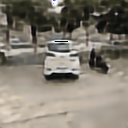

Epoch: 80/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.0036] 

Adjusting learning rate of group 0 to 8.7446e-05.
PSNR1 = 25.17317771911621


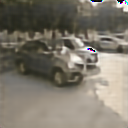

PSNR2 = 22.326318740844727


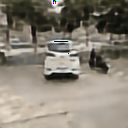

Epoch: 81/200


100%|██████████| 64/64 [00:16<00:00,  3.81it/s, loss=0.00391]

Adjusting learning rate of group 0 to 8.4822e-05.
PSNR1 = 26.19139862060547


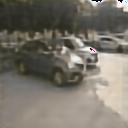

PSNR2 = 21.517427444458008


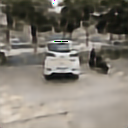

Epoch: 82/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.0051] 

Adjusting learning rate of group 0 to 8.2278e-05.
PSNR1 = 25.964868545532227


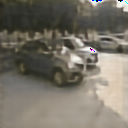

PSNR2 = 21.030197143554688


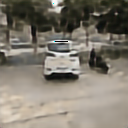

Epoch: 83/200


100%|██████████| 64/64 [00:16<00:00,  3.81it/s, loss=0.0034] 

Adjusting learning rate of group 0 to 7.9809e-05.
PSNR1 = 25.71986961364746


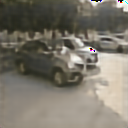

PSNR2 = 22.037153244018555


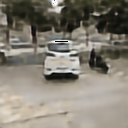

Epoch: 84/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.00347]

Adjusting learning rate of group 0 to 7.7415e-05.
PSNR1 = 25.786293029785156


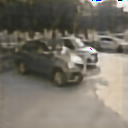

PSNR2 = 21.14073944091797


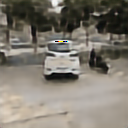

Epoch: 85/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.00364]

Adjusting learning rate of group 0 to 7.5093e-05.
PSNR1 = 25.89828872680664


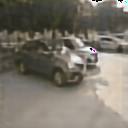

PSNR2 = 21.682327270507812


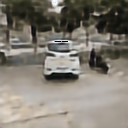

Epoch: 86/200


100%|██████████| 64/64 [00:16<00:00,  3.81it/s, loss=0.00367]

Adjusting learning rate of group 0 to 7.2840e-05.
PSNR1 = 26.020601272583008


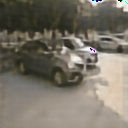

PSNR2 = 21.192386627197266


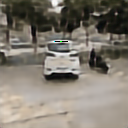

Epoch: 87/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.00372]

Adjusting learning rate of group 0 to 7.0655e-05.
PSNR1 = 26.219131469726562


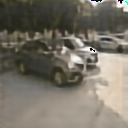

PSNR2 = 21.165828704833984


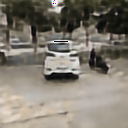

Epoch: 88/200


100%|██████████| 64/64 [00:16<00:00,  3.81it/s, loss=0.00387]

Adjusting learning rate of group 0 to 6.8535e-05.
PSNR1 = 26.00385284423828


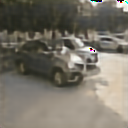

PSNR2 = 21.43619155883789


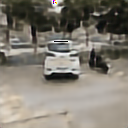

Epoch: 89/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.00322]

Adjusting learning rate of group 0 to 6.6479e-05.
PSNR1 = 25.846797943115234


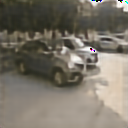

PSNR2 = 21.48890495300293


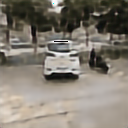

Epoch: 90/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.00405]

Adjusting learning rate of group 0 to 6.4485e-05.
PSNR1 = 26.02402114868164


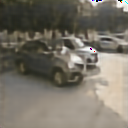

PSNR2 = 21.234416961669922


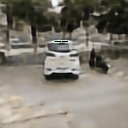

Epoch: 91/200


100%|██████████| 64/64 [00:16<00:00,  3.81it/s, loss=0.00336]

Adjusting learning rate of group 0 to 6.2550e-05.
PSNR1 = 26.15647315979004


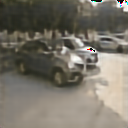

PSNR2 = 21.66008758544922


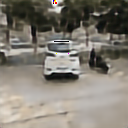

Epoch: 92/200


100%|██████████| 64/64 [00:16<00:00,  3.81it/s, loss=0.00332]

Adjusting learning rate of group 0 to 6.0674e-05.
PSNR1 = 25.73394775390625


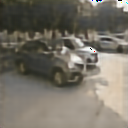

PSNR2 = 21.127918243408203


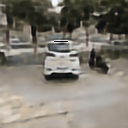

Epoch: 93/200


100%|██████████| 64/64 [00:16<00:00,  3.81it/s, loss=0.00363]

Adjusting learning rate of group 0 to 5.8853e-05.
PSNR1 = 25.793933868408203


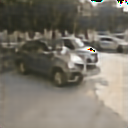

PSNR2 = 22.191936492919922


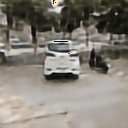

Epoch: 94/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.004]  

Adjusting learning rate of group 0 to 5.7088e-05.
PSNR1 = 25.885669708251953


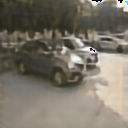

PSNR2 = 21.86272430419922


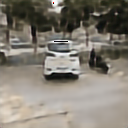

Epoch: 95/200


100%|██████████| 64/64 [00:16<00:00,  3.81it/s, loss=0.00415]

Adjusting learning rate of group 0 to 5.5375e-05.
PSNR1 = 26.073415756225586


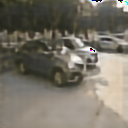

PSNR2 = 21.548612594604492


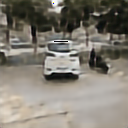

Epoch: 96/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.0041] 

Adjusting learning rate of group 0 to 5.3714e-05.
PSNR1 = 26.257579803466797


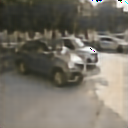

PSNR2 = 21.21938705444336


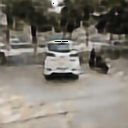

Epoch: 97/200


100%|██████████| 64/64 [00:16<00:00,  3.81it/s, loss=0.00416]

Adjusting learning rate of group 0 to 5.2102e-05.
PSNR1 = 25.858610153198242


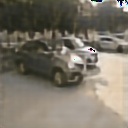

PSNR2 = 22.001327514648438


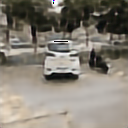

Epoch: 98/200


100%|██████████| 64/64 [00:16<00:00,  3.79it/s, loss=0.0039] 

Adjusting learning rate of group 0 to 5.0539e-05.
PSNR1 = 26.047195434570312


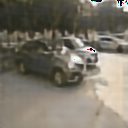

PSNR2 = 22.202741622924805


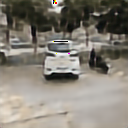

Epoch: 99/200


100%|██████████| 64/64 [00:16<00:00,  3.81it/s, loss=0.00397]

Adjusting learning rate of group 0 to 4.9023e-05.
PSNR1 = 26.211088180541992


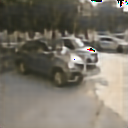

PSNR2 = 22.04034996032715


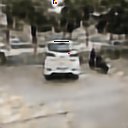

Epoch: 100/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.00349]


Adjusting learning rate of group 0 to 4.7553e-05.
Epoch: 101/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.00365]

Adjusting learning rate of group 0 to 4.6126e-05.
PSNR1 = 26.202106475830078


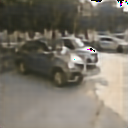

PSNR2 = 22.0822696685791


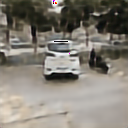

Epoch: 102/200


100%|██████████| 64/64 [00:16<00:00,  3.81it/s, loss=0.00464]

Adjusting learning rate of group 0 to 4.4742e-05.
PSNR1 = 25.79147720336914


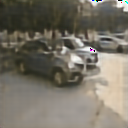

PSNR2 = 21.32737922668457


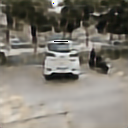

Epoch: 103/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.00355]

Adjusting learning rate of group 0 to 4.3400e-05.
PSNR1 = 26.042774200439453


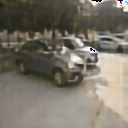

PSNR2 = 21.91460609436035


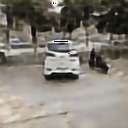

Epoch: 104/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.00306]

Adjusting learning rate of group 0 to 4.2098e-05.
PSNR1 = 26.226119995117188


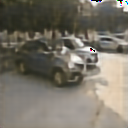

PSNR2 = 21.87094497680664


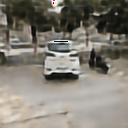

Epoch: 105/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.00407]

Adjusting learning rate of group 0 to 4.0835e-05.
PSNR1 = 26.375652313232422


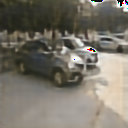

PSNR2 = 21.956119537353516


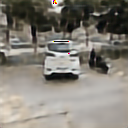

Epoch: 106/200


100%|██████████| 64/64 [00:16<00:00,  3.81it/s, loss=0.00392]

Adjusting learning rate of group 0 to 3.9610e-05.
PSNR1 = 26.15902328491211


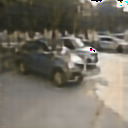

PSNR2 = 21.22053337097168


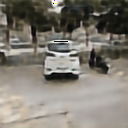

Epoch: 107/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.0037] 

Adjusting learning rate of group 0 to 3.8422e-05.
PSNR1 = 26.35071563720703


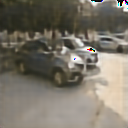

PSNR2 = 22.144973754882812


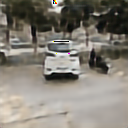

Epoch: 108/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.004]  

Adjusting learning rate of group 0 to 3.7269e-05.
PSNR1 = 26.025226593017578


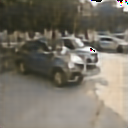

PSNR2 = 21.858064651489258


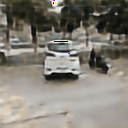

Epoch: 109/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.0033] 

Adjusting learning rate of group 0 to 3.6151e-05.
PSNR1 = 26.304698944091797


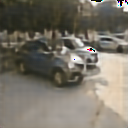

PSNR2 = 21.673381805419922


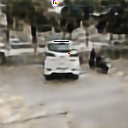

Epoch: 110/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.00361]

Adjusting learning rate of group 0 to 3.5066e-05.
PSNR1 = 26.22641372680664


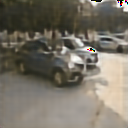

PSNR2 = 21.233745574951172


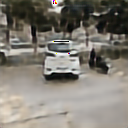

Epoch: 111/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.00334]

Adjusting learning rate of group 0 to 3.4014e-05.
PSNR1 = 26.065834045410156


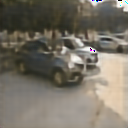

PSNR2 = 21.583934783935547


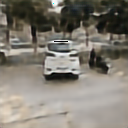

Epoch: 112/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.00355]

Adjusting learning rate of group 0 to 3.2994e-05.
PSNR1 = 26.12778091430664


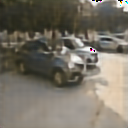

PSNR2 = 21.26612091064453


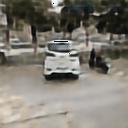

Epoch: 113/200


100%|██████████| 64/64 [00:16<00:00,  3.81it/s, loss=0.00325]

Adjusting learning rate of group 0 to 3.2004e-05.
PSNR1 = 26.250850677490234


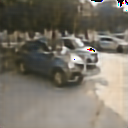

PSNR2 = 22.050277709960938


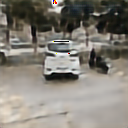

Epoch: 114/200


100%|██████████| 64/64 [00:16<00:00,  3.80it/s, loss=0.00357]

Adjusting learning rate of group 0 to 3.1044e-05.
PSNR1 = 26.27306365966797


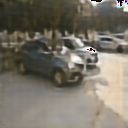

PSNR2 = 21.703365325927734


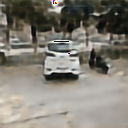

Epoch: 115/200


 95%|█████████▌| 61/64 [00:16<00:00,  3.80it/s, loss=0.00404]

In [ ]:
train(RAE, train_loader, epochs=200, lr=1e-3)